In [7]:
import sys
sys.path.append("..")  # Adjusts the path to include the parent directory

from rps_simulation.rps_base import RPS_core  # Importing RPS_core class from rps_base.py
from rps_simulation.rps_multirun import RPS_multirun
from rps_simulation.learning_curves import exponential_learning, logistic_learning  # Learning Curves
from rps_simulation.forgetting_curves import exponential_forgetting, spacing_effect # Forgetting Curves, Spacing Effect
from rps_simulation.practice_rate import simple_linear_rate  # Practice-Rate Function
from rps_simulation.waiting_times import exponential_waiting_time  # Waiting-Time Distribution
#from rps_simulation.dynamical_models import logistic_model, general_model # Dynamical Model
#from rps_simulation.sensitivity_analysis import RPS_sensitivity # sensitivity analysis


import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
#import sympy as sp
import matplotlib.pyplot as plt
import seaborn as sns

# Colour codes for concave and sigmoid curves:
concave_colour = '#466be8'
sigmoid_colour = '#f77150'

plot_dpi = 300 #dpi at which plots will be saved

np.random.seed(10)

## 1. Concave (Exp) Learning Curve:


In [12]:
# Hyperparameters - spacing effect
ϵ = 2
s_spacing = 0.5 
beta_min = 0

n_iti = 201 # number of different values of waiting times
n_ret_int = 4 # number of retention interval

# Independent variables:
iti = np.linspace(0,5, n_iti) # inter-trial interval/ waiting time
#ret_int = np.linspace(5, 10, n_ret_int) # retention intervals
ret_int = [5, 10, 15, 20] # retention intervals

# initial conditions;
beta0 = 0.05 # starting forgetting rate
s0 = 0.8 # starting skill

# learning conditions:
exp_update = exponential_learning(alpha=0.002, skill_max=1)

# Data arrays be filled after calculations:
beta1 = np.zeros((n_ret_int, n_iti)) # beta after first trial:
beta2 = np.zeros((n_ret_int, n_iti)) # final beta
s1 = np.zeros((n_ret_int, n_iti)) # skill after P1
s2 = np.zeros((n_ret_int, n_iti)) # skill after P2


## Run Simulations and fill arrays:
for i in range(n_ret_int): # loop over all retention intervals
    for j in range(n_iti): # loop over all inter-trial intervals
        s1_bef = exponential_forgetting(forgetting_rate=beta0).calculate(s0, iti[j]) # skill just before trial 1
        s1_tmp = exp_update.updated_skill(s1_bef) # skill after trial 1
        s1[i,j] = s1_tmp
    
        # calculate forgetting rate after trial 1:
        β1 = spacing_effect(beta_min=0.01, beta_max=beta0, e=ϵ, s=s_spacing).calc_forgetting_rate([iti[j]])
        beta1[i,j]=β1
    
        # Calculate final skill:
        s2_bef = exponential_forgetting(forgetting_rate=β1).calculate(s1_tmp, ret_int[i])
        s2_tmp = exp_update.updated_skill(s2_bef) # final skill after retention interval
        s2[i,j] = s2_tmp
    
        # calculate final forgetting:
        Δt_list = [iti[j], ret_int[i]] # list of wait times
        β2 = spacing_effect(beta_min=0.01, beta_max=β1, e=ϵ, s=s_spacing).calc_forgetting_rate(Δt_list)
        beta2[i,j]=β1
    
    

# Make dataframe from generated data above:
dict_spacing = {'iti': list(iti)*n_ret_int, 
               'ret_int': np.repeat(ret_int, n_iti), 
                'final_skill': s2.flatten()}

df_spacing = pd.DataFrame(dict_spacing) # make df from dict
# df_spacing.head(10)

### 1.1 Effect of Inter-Trial Interval on Final Skil 


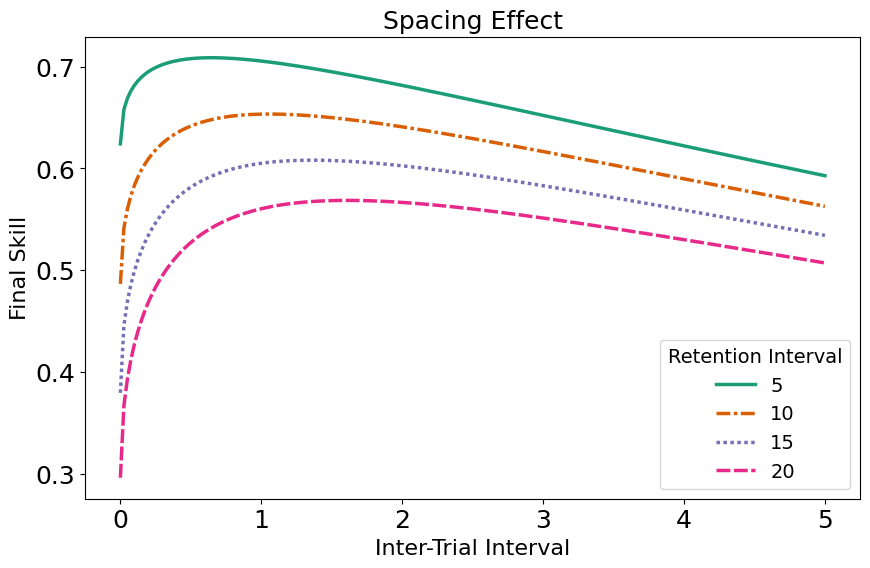

In [13]:
# Set the style and figure size
plt.style.use('default')
plt.figure(figsize=(10, 6))

# Create the KDE plot with hue
sns.lineplot(
    data=df_spacing,
    x='iti',
    y='final_skill',
    hue='ret_int',       # color-coded by ret_int
    style='ret_int',     # also assign line style by ret_int
    linewidth=2.5,
    dashes=[(None,None), (4,1,1,1), (1,1), (4,1)],  # each tuple is (dash_length, gap_length, ...)
    palette=['#1b9e77','#d95f02','#7570b3','#e7298a']  # or any custom list of colors
)


plt.title('Spacing Effect', fontsize=18)
plt.xlabel('Inter-Trial Interval', fontsize=16)
plt.ylabel('Final Skill', fontsize=16)

# Adding a legend with a title
plt.legend(title='Retention Interval', fontsize=14, title_fontsize=14)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig('../plots/spacing_effect_RT.png', dpi=512)
plt.show()

# Simulation Incorporating Spacing:

Simulation for one agent, using exponential curve:

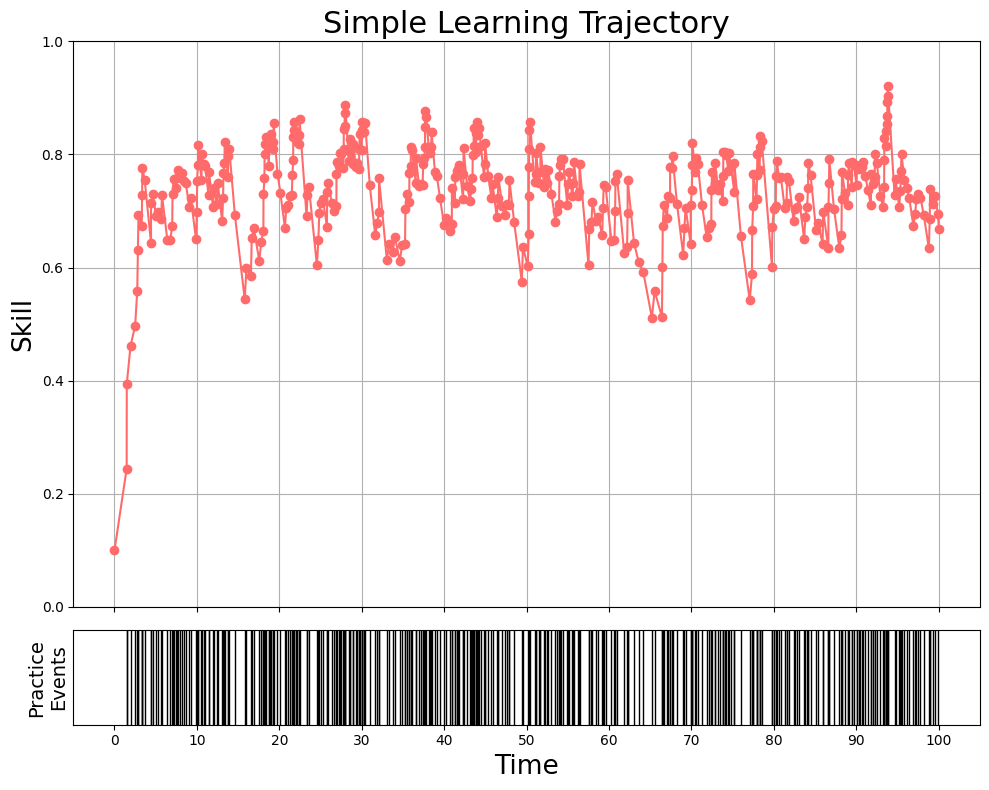

In [15]:
## Defining the learning, forgetting and practice functions:
exp_learning = exponential_learning(alpha=0.2) # alpha is the learning rate
simple_prac_func = simple_linear_rate(a=0.2, b=5) # sample practice function
exp_forgetting = exponential_forgetting(forgetting_rate=0.4) # setting forgetting function to exponential 
spacing = spacing_effect(beta_min=0.2, e=0.01, s=0.5)

# Initializing the RPS_core class:
sample_concave = RPS_core(learning_func = exp_learning,
                    forgetting_func = exp_forgetting,
                    practice_rate_func = simple_prac_func,
                    waiting_time_dist = exponential_waiting_time,
                    spacing_func = spacing,
                    initial_skill=0.1, initial_practice_rate=1, max_time=100)


# run simulation:
sample_concave.run_simulation()

# simple learning trajectory with markers for practice events:
#sample_concave.plot_simple_trajectory()

# plot trajectory
sample_concave.plot_combined_trajectory()



In [16]:
# Get data form the simulation run and collect it in a dictionary
sample_data = sample_concave.data()

ss = sample_data['skill_levels']
pts = sample_data['practice_times']
tls = sample_data['time_lags']
frs = sample_data['forgetting_rates']

print(len(ss), len(pts), len(tls), len(frs))
print(sample_data['total_practice_events'])

418 418 415 416
416


# 2. Concave and Sigmoid Sims with Spacing:

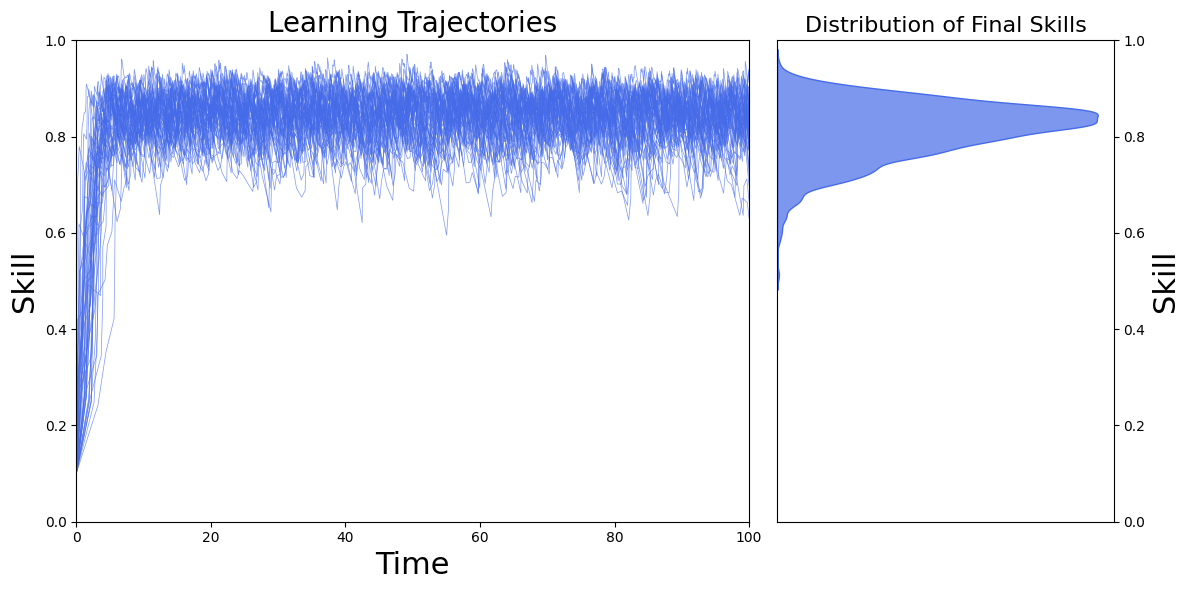

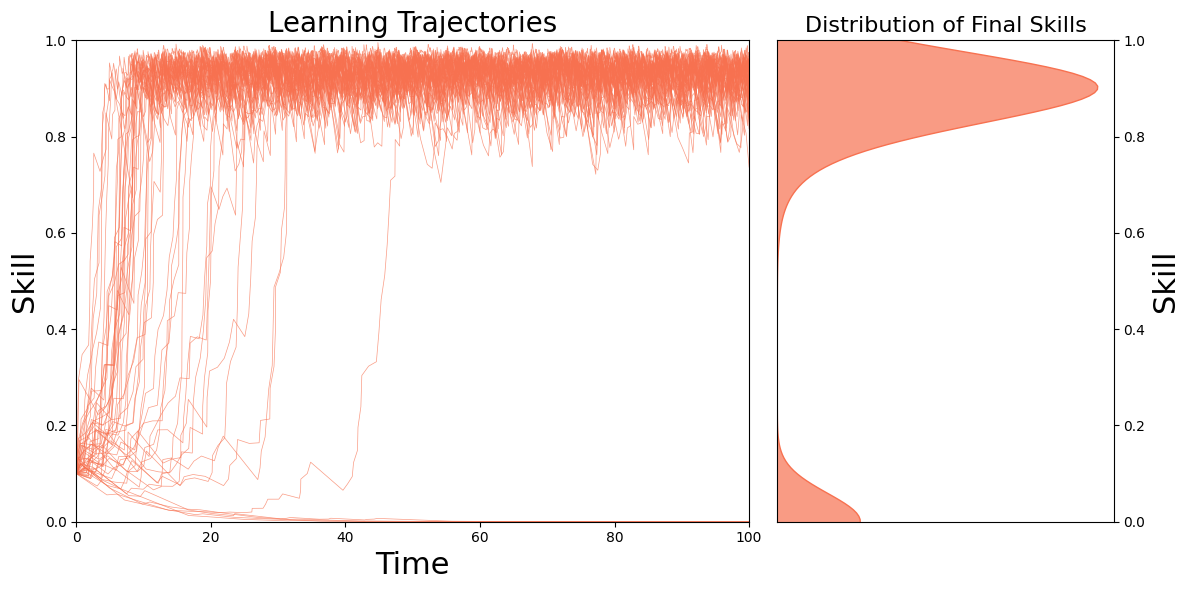

In [18]:
########## Concave Simulation and Plots ##########

## Defining the learning, forgetting and practice functions:
exp_learning = exponential_learning(alpha=0.2) # alpha is the learning rate
simple_prac_func = simple_linear_rate(a=0.2, b=5) # sample practice function
exp_forgetting = exponential_forgetting(forgetting_rate=0.2) # setting forgetting function to exponential 
spacing = spacing_effect(beta_min=0.1, e=0.01, s=0.5)


# initializing the class
concave_spacing_sims = RPS_multirun(learning_func=exp_learning,
                            forgetting_func=exp_forgetting,
                            practice_rate_func=simple_prac_func,
                            waiting_time_dist=exponential_waiting_time,
                            spacing_func = spacing,
                            initial_skill = 0.1, 
                            initial_practice_rate = 1, 
                            max_time = 100,
                            n_sims=1000)
# running the simulations
concave_spacing_sims.run_multiple_sims() 

#concave_colour = '#466be8'

# plot final skill histogram:
concave_spacing_sims.plot_trajectory_and_histogram(colour_lineplots=concave_colour, colour_histogram=concave_colour, n_plots=50, 
   bw_adjust=0.7,save_location='../plots/concave_spacing_sim_summ.jpg', save_dpi=plot_dpi)

# concave_spacing_sims.plot_trajectory_and_histogram(colour_lineplots=concave_colour, colour_histogram=concave_colour, n_plots=50, bw_adjust=0.7)




########## Sigmoid Simulation and Plots ##########

## Defining the learning, forgetting and practice functions:
log_learning = logistic_learning(alpha=0.4) # alpha is the learning rate
simple_prac_func = simple_linear_rate(a=0.2, b=5) # sample practice function
exp_forgetting = exponential_forgetting(forgetting_rate=0.2) # setting forgetting function to exponential 
spacing = spacing_effect(beta_min=0.1, e=0.01, s=0.5)


# initializing the class
sigmoid_spacing_sims = RPS_multirun(learning_func=log_learning,
                            forgetting_func=exp_forgetting,
                            practice_rate_func=simple_prac_func,
                            waiting_time_dist=exponential_waiting_time,
                            spacing_func = spacing,
                            initial_skill = 0.1, 
                            initial_practice_rate = 1, 
                            max_time = 100,
                            n_sims=1000)
# running the simulations
sigmoid_spacing_sims.run_multiple_sims() 

#concave_colour = '#466be8'
 
# combined_plot of learning trajectories + histogram of final skills
sigmoid_spacing_sims.plot_trajectory_and_histogram(colour_lineplots=sigmoid_colour, colour_histogram=sigmoid_colour, n_plots=50, 
   bw_adjust=0.7,save_location='../plots/sigmoid_spacing_sim_summ.png', save_dpi=plot_dpi)

#sigmoid_spacing_sims.plot_trajectory_and_histogram(colour_lineplots=sigmoid_colour, colour_histogram=sigmoid_colour, n_plots=50, bw_adjust=0.7)


Interestingly, the forgetting rates over time for experts vs. quitters also show 2 clusters. Experts who keep practicing and engaging with the task have a lower forgetting rate. 

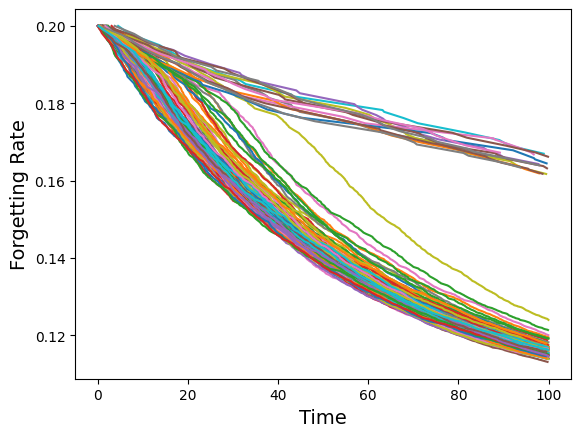

In [22]:
lol = sigmoid_spacing_sims.all_forgetting_rates
for i in range(100):
    plt.plot(sigmoid_spacing_sims.all_practice_times[i][1:-1], sigmoid_spacing_sims.all_forgetting_rates[i])

plt.ylabel('Forgetting Rate', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.show()